In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc as misc
import segmentation_model

%matplotlib inline

RESIZE_DIM=128

FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('model_dir', '/tmp/segmentation_train',
                           """Directory where model is stored.""")
tf.app.flags.DEFINE_string('image_file', 
                           '/Users/xuehan.xiong/framework/face_analysis/data/hair_test00.jpg',
                           """Absolute path to image file.""")

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
        
def resize_image(image):
    height,width = image.shape[:2]
    scale = float(RESIZE_DIM) / float(np.minimum(width,height))
    resized_image = cv2.resize(image,(0,0),fx=scale,fy=scale)
    assert np.minimum(resized_image.shape[0],resized_image.shape[1]) == RESIZE_DIM
    return resized_image

def preprocess(image):
    image = np.float32(image)
    image = image * (1. / 255) - 0.5
    return image

In [3]:
image = FLAGS.image_file;
if not tf.gfile.Exists(image):
    tf.logging.fatal('File does not exist %s', image)
image_data = misc.imread(image)
# in case of 4-channel image, remove the alpha channel
if image_data.shape[2] > 3:
    image_data = image_data[:,:,:3]
resized_image = resize_image(image_data)
resized_image = preprocess(resized_image)
assert resized_image.shape[2] == 3
height,width = resized_image.shape[:2]
resized_image = np.reshape(resized_image,(1,height,width,3))

(1, 171, 128, 3)
(168, 128)


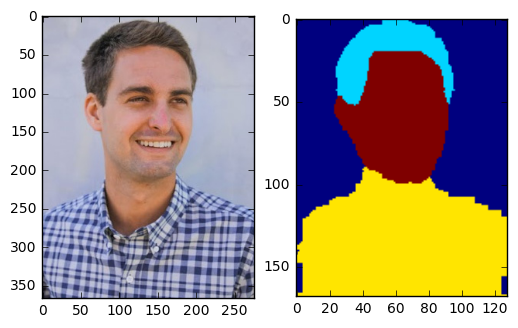

In [6]:
with tf.Graph().as_default():
    image_placeholder = tf.placeholder(tf.float32, shape=(None,None,None,3))
    logits = segmentation_model.inference(image_placeholder)
    _,indices = tf.nn.top_k(logits, k=1, sorted=False)
    squeezed_indices = tf.squeeze(indices)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        model_checkpoint_path = os.path.join(FLAGS.model_dir,'model.ckpt-2000')
        saver.restore(sess, model_checkpoint_path)
        predictions = sess.run(squeezed_indices, feed_dict={image_placeholder: resized_image})
        print resized_image.shape
        print predictions.shape
        plt.subplot(121)
        plt.imshow(image_data)
        plt.subplot(122)
        plt.imshow(predictions)
        plt.show()
        
        